In [1]:
import pandas,numpy,seaborn

import scipy,scipy.stats

import matplotlib,matplotlib.pyplot
matplotlib.rcParams.update({'font.size':40,'font.family':'Arial','xtick.labelsize':20,'ytick.labelsize':20,'axes.labelsize':33})
matplotlib.rcParams['pdf.fonttype']=42

# 0. user defined variables

In [2]:
ribo1_file='/Volumes/omics4tb2/alomana/projects/TLR/results/yeast_358309644/kallisto.1e2.fr/WTS1/abundance.tsv'
ribo2_file='/Volumes/omics4tb2/alomana/projects/TLR/results/yeast_358309644/kallisto.1e2.fr/WTS3/abundance.tsv'

mrna1_file='/Volumes/omics4tb2/alomana/projects/TLR/results/yeast_358309644/kallisto.1e2.fr/64/abundance.tsv'
mrna2_file='/Volumes/omics4tb2/alomana/projects/TLR/results/yeast_358309644/kallisto.1e2.fr/65/abundance.tsv'

# 1. read data

In [3]:
ribo1=pandas.read_csv(ribo1_file,sep='\t')
ribo2=pandas.read_csv(ribo2_file,sep='\t')
mRNA1=pandas.read_csv(mrna1_file,sep='\t')
mRNA2=pandas.read_csv(mrna2_file,sep='\t')

# 2. manipulate data

In [4]:
ribo1.set_index('target_id',inplace=True)
ribo2.set_index('target_id',inplace=True)
mRNA1.set_index('target_id',inplace=True)
mRNA2.set_index('target_id',inplace=True)

In [5]:
ribo1.drop(columns=['length','eff_length','est_counts'],inplace=True)
ribo2.drop(columns=['length','eff_length','est_counts'],inplace=True)
mRNA1.drop(columns=['length','eff_length','est_counts'],inplace=True)
mRNA2.drop(columns=['length','eff_length','est_counts'],inplace=True)

In [6]:
ribo1.rename(columns={"tpm": "ribo1"},inplace=True)
ribo2.rename(columns={"tpm": "ribo2"},inplace=True)
mRNA1.rename(columns={"tpm": "mRNA1"},inplace=True)
mRNA2.rename(columns={"tpm": "mRNA2"},inplace=True)

In [7]:
ribo1.head()

,ribo1
target_id,
YBR024W_mRNA,6.98826
YDL245C_mRNA,0.00000
YBR232C_mRNA,0.00000
YDR320W-B_mRNA,0.00000
YBR021W_mRNA,5.61890


In [8]:
ribo2.head()

,ribo2
target_id,
YBR024W_mRNA,9.05898
YDL245C_mRNA,0.00000
YBR232C_mRNA,0.00000
YDR320W-B_mRNA,0.00000
YBR021W_mRNA,4.82412


In [9]:
df=ribo1.join(ribo2)
df=df.join(mRNA1)
df=df.join(mRNA2)
df.head()

,ribo1,ribo2,mRNA1,mRNA2
target_id,,,,
YBR024W_mRNA,6.98826,9.05898,16.974400,18.053400
YDL245C_mRNA,0.00000,0.00000,0.013221,0.007805
YBR232C_mRNA,0.00000,0.00000,0.285666,0.322089
YDR320W-B_mRNA,0.00000,0.00000,0.000000,0.000000
YBR021W_mRNA,5.61890,4.82412,9.936150,8.040710


# 3. analysis

In [10]:
gene_names=df.index.to_list()
print('{} genes found'.format(len(gene_names)))

6612 genes found


## 3.1. remove low expression genes

In [11]:
selected_genes=[]
for gene_name in gene_names:
    a=numpy.max(numpy.array(df.loc[gene_name,:]))
    if a > 10:
        selected_genes.append(gene_name)
print('{} genes selected'.format(len(selected_genes)))

4773 genes selected


## 3.2. keep consistent genes, within abs log2 FC 1

In [12]:
df=df+1

In [13]:
consistent_genes=[]
for gene_name in selected_genes:
    ratio=df.loc[gene_name,'ribo1']/df.loc[gene_name,'ribo2']
    a=abs(numpy.log2(ratio))
    
    ratio=df.loc[gene_name,'mRNA1']/df.loc[gene_name,'mRNA2']
    b=abs(numpy.log2(ratio))
    
    if numpy.max([a,b]) < 1:
        consistent_genes.append(gene_name)

print('{} consistent genes'.format(len(consistent_genes)))

4658 consistent genes


## 3.3. average and computet ratios

In [14]:
setx=[]; sety=[]
hollowx=[]; hollowy=[]

for gene_name in consistent_genes:
    
    log2M=numpy.log2(df.loc[gene_name,['mRNA1','mRNA2']].mean())
    log10M=numpy.log10(df.loc[gene_name,['mRNA1','mRNA2']].mean())
    log2F=numpy.log2(df.loc[gene_name,['ribo1','ribo2']].mean())
    
    m=log10M
    r=log2F-log2M
    
    if numpy.max([m,r]) > 0: # exclude zero values
        
        # differenciate between trasncripts with or without footprints or inverse
        if log2F == 0:
            hollowx.append(m); hollowy.append(r)
        elif log2M == 0:
            hollowx.append(m); hollowy.append(r)
        else:        
            setx.append(m); sety.append(r)    

# 4. regression model

In [15]:
print('number of elements:',len(setx))
# perform regression analysis
print('\t regression results:')
slope,intercept,r_value,p_value,std_err=scipy.stats.linregress(setx,sety)
print('\t\t slope',slope)
print('\t\t intercept',intercept)
print('\t\t r_value',r_value)
print('\t\t pvalue',p_value)
print('\t\t std_err',std_err)

# compute for the model
m=slope
c=intercept
expected=list(m*numpy.array(setx)+c)

number of elements: 4638
	 regression results:
		 slope 0.47525159623484575
		 intercept -1.9404878517066946
		 r_value 0.23335588001069357
		 pvalue 2.1408975084362718e-58
		 std_err 0.02908534575492769


# 5. dot plot

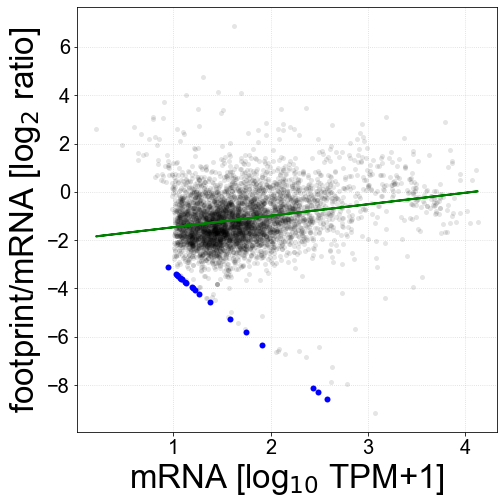

In [16]:
matplotlib.pyplot.figure(None,(8,8))

matplotlib.pyplot.plot(setx,sety,'o',color='black',alpha=0.1,ms=5,mew=0)
matplotlib.pyplot.plot(hollowx,hollowy,'o',alpha=1,mew=0,color='blue')

matplotlib.pyplot.xlabel('mRNA [log$_{10}$ TPM+1]')
matplotlib.pyplot.ylabel('footprint/mRNA [log$_{2}$ ratio]')
matplotlib.pyplot.plot(setx,expected,'-',lw=2,color='green')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()

# 6. regression plot

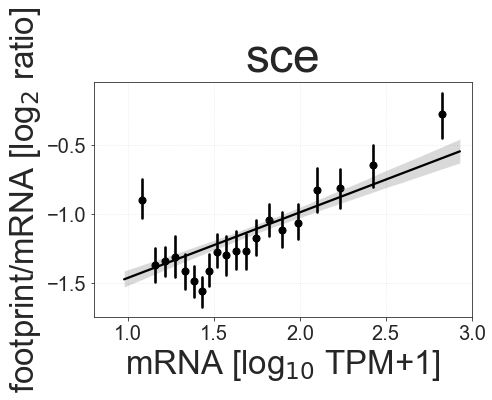

In [17]:
seaborn.set_style("ticks")
matplotlib.pyplot.figure(None,(8,6))

seaborn.regplot(x=setx,y=sety,x_bins=20,order=1,color='black')

matplotlib.pyplot.xlim([0.8,3])

matplotlib.pyplot.xlabel('mRNA [log$_{10}$ TPM+1]')
matplotlib.pyplot.ylabel('footprint/mRNA [log$_{2}$ ratio]')
matplotlib.pyplot.title('sce')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.savefig('figure1.pdf')

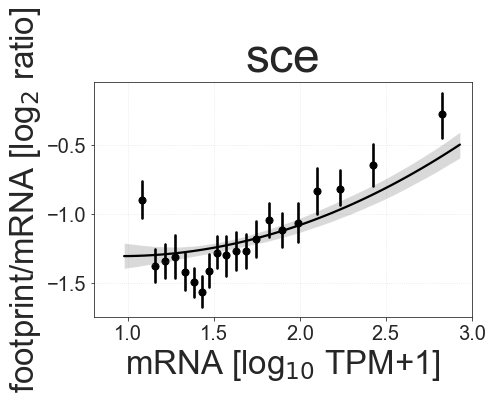

In [18]:
seaborn.set_style("ticks")
matplotlib.pyplot.figure(None,(8,6))

seaborn.regplot(x=setx,y=sety,x_bins=20,order=2,color='black')

matplotlib.pyplot.xlim([0.8,3])

matplotlib.pyplot.xlabel('mRNA [log$_{10}$ TPM+1]')
matplotlib.pyplot.ylabel('footprint/mRNA [log$_{2}$ ratio]')
matplotlib.pyplot.title('sce')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.savefig('figure2.pdf')

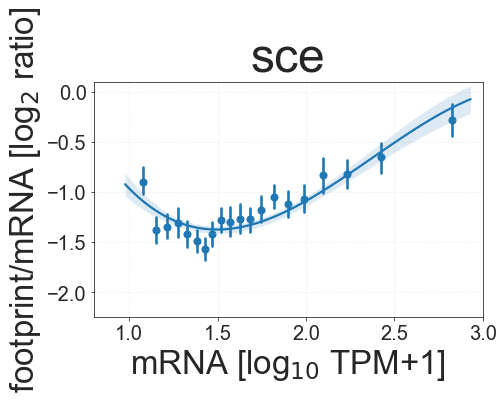

In [22]:
seaborn.set_style("ticks")
matplotlib.pyplot.figure(None,(8,6))

seaborn.regplot(x=setx,y=sety,x_bins=20,order=3,color='tab:blue')


ub=0.1; lb=-2.25
matplotlib.pyplot.ylim([lb,ub])

matplotlib.pyplot.xlim([0.8,3])

matplotlib.pyplot.xlabel('mRNA [log$_{10}$ TPM+1]')
matplotlib.pyplot.ylabel('footprint/mRNA [log$_{2}$ ratio]')
matplotlib.pyplot.title('sce')

matplotlib.pyplot.grid(True,alpha=0.5,ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.savefig('figure3.pdf')